**Remarks**

In this notebook, we will learn about deep analysis in amazon-cell-phone-analysis. Yeayy! You must review my notebook to gain more knowledge about what I was written before. I used different method: Gensim, BERT, FastText, Word2Vec and LSTM. Let's check it out!

In [2]:
# import library
# 1. dataframe environment
import numpy as np 
import pandas as pd
import tqdm
import sklearn

# 2. NLP tools
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import re, os, csv, math, codecs, shutil, string
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob
from collections import Counter

# 3. Modelling tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 4. Visualization tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Tensor Environment
from tensorflow.keras import preprocessing, layers, losses, regularizers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# GPU Testing
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [4]:
# dataset preparation from Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d grikomsn/amazon-cell-phones-reviews
!unzip "/content/amazon-cell-phones-reviews.zip"

 57% 5.00M/8.84M [00:00<00:00, 26.2MB/s]
100% 8.84M/8.84M [00:00<00:00, 35.1MB/s]
Archive:  /content/amazon-cell-phones-reviews.zip
  inflating: 20191226-items.csv      
  inflating: 20191226-reviews.csv    


In [6]:
# showing dataset
review_data = pd.read_csv("/content/20191226-reviews.csv")
review_data.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [7]:
# shape of dataframe
print("The dataset contains {0[0]: .0f} rows and {0[1]:.0f} columns".format(review_data.shape))

The dataset contains  67986 rows and 8 columns


In [8]:
# preprocessing data
review_data = review_data.rename(columns={'overall':'rating',
                                          'asin':'productID'}, inplace=False)
review_data["reviewtext"] = review_data.title + review_data.body
review_data.dropna(axis=0, how="any", inplace=True)

def clean_text(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

review_data.reviewtext = review_data['reviewtext'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewtext'].apply(lambda x:len(str(x).split()))
review_data.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,productID,name,rating,date,verified,title,body,helpfulVotes,reviewtext,Num_words_text
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,def not best but not worsti had the samsung a6...,239
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,text messaging doesnt workdue software issue b...,112
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,love this phonethis great reliable phone also ...,108
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,love the phone buti love the phone and all bec...,84
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,great phone service and options lousy casethe ...,107


In [9]:
# counting rating
print(review_data.rating.value_counts())

5    12960
1     7061
4     3280
3     2032
2     1873
Name: rating, dtype: int64


In [10]:
# counting sentence length
print("Number of data: ",len(review_data))
print("Maximum sentence length", review_data['Num_words_text'].max())

Number of data:  27206
Maximum sentence length 4249


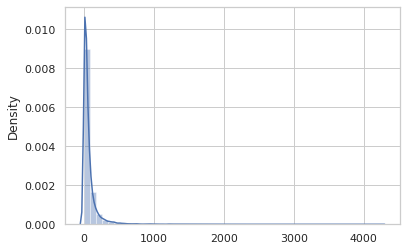

In [12]:
# checking number of length distribution
sns.set(style="whitegrid")
sns.distplot(x=review_data['Num_words_text'])
plt.show();

In [21]:
# cutting dataset : Short (<100) and Long (>100)
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
print("Number of short review: ", len(review_data[mask]))

Number of short review:  14036


In [19]:
mask = (review_data['Num_words_text'] >= 100)
print("Number of long review: ", len(review_data[mask]))

Number of long review:  5287


We choose short review for our basic information learning.

In [22]:
# maximum length in short review
print("Maximum length: ", review_data[mask]['Num_words_text'].max())

Maximum length:  99


In [23]:
short_review = review_data[mask]

# changing code
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0

short_review.rating = short_review.rating.apply(get_sentiment)
short_review.head()

,productID,name,rating,date,verified,title,body,helpfulVotes,reviewtext,Num_words_text
3,B0000SX2UC,amy m. teague,1,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,love the phone buti love the phone and all bec...,84
7,B0000SX2UC,Matt,1,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0,problem with 3588i universal headsetthe 3599i ...,56
8,B0000SX2UC,Charles Cook,1,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0,cool phoneive never owned nokia phone before t...,39
9,B0000SX2UC,Amazon Customer,1,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0,pissed offa little bitok well school and need ...,61
44,B001AO4OUC,"Ron Malinowski, Jr.",0,"November 19, 2012",True,Boost Mobile no Longer allows IDEN service,I bought this phone and found out IDEN phones ...,2.0,boost mobile longer allows iden servicei bough...,38


In [24]:
# filtering dataset
filtered_data = short_review.groupby('productID').filter(lambda x:len(x)>=20)
print("Counting data: ", len(filtered_data))
print(filtered_data.rating.value_counts())

Counting data:  11406
1    7198
0    4208
Name: rating, dtype: int64


In [25]:
# create train dataset
train_data = filtered_data[['reviewtext', 'rating']]

In [30]:
# create test data
mask = (review_data['Num_words_text'] < 100)
short_review_test = review_data[mask]
short_review_test.rating = short_review_test.rating.apply(get_sentiment)
filtered_data = short_review_test.groupby('productID').filter(lambda x:len(x)>=10)
print("Counting data: ", len(filtered_data))
print(filtered_data.rating.value_counts())
test_data = filtered_data[['reviewtext', 'rating']]

Counting data:  20926
1    13928
0     6998
Name: rating, dtype: int64


In [37]:
# splitting data
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewtext'].tolist(),
                                                    train_data['rating'].tolist(),
                                                    test_size=0.3, stratify=train_data['rating'].tolist(),
                                                    random_state=42)
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:7984
Class distributionCounter({1: 5038, 0: 2946})
Valid data len:3422
Class distributionCounter({1: 2160, 0: 1262})


In [38]:
# NLP Process
# 1. Tokenizer
num_words = 50000
tokenizer = Tokenizer(num_words=num_words, oov_token="unk")
tokenizer.fit_on_texts(X_train)

# 2. Convert tokens into sequences
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_valid = np.array(tokenizer.texts_to_sequences(X_valid))
X_test = np.array(tokenizer.texts_to_sequences(test_data['reviewtext'].tolist()))

# 3. Add post padding with maxlenth
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_valid = pad_sequences(X_valid, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

# 4. Build in array
train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['rating'].tolist())

# 5. Tensor array
train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, test_labels))

In [34]:
# Checking number test data
# print('Train data len:'+str(len(x_train)))
# print('Class distribution'+str(Counter(train_labels)))

# print('Validation data len:'+str(len(x_valid)))
# print('Class distribution'+str(Counter(valid_labels)))

# print('Test data len:'+str(len(x_test)))
# print('Class distribution'+str(Counter(test_labels)))

In [35]:
# Showing tensor array
# count =0
# print('======Train dataset ====')
# for value,label in train_ds:
#     count += 1
#     print(value,label)
#     if count==1:
#         break
# count =0
# print('======Testing dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==1:
#         break
# count =0
# print('======Validation dataset ====')
# for value,label in valid_ds:
#     count += 1
#     print(value,label)
#     if count==1:
#         break

**LSTM Analysis**

It is the first step analysis. Enjoy learn!

In [40]:
max_features = 50000
embedding_dim = 16
sequence_length = 100

# layer 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim,
                                    input_length=sequence_length,
                                    embeddings_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))

# layer 2
model.add(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2,
                               return_sequences=True, kernel_regularizer=regularizers.l2(0.005),
                               bias_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Flatten())

# layer 3
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))

# layer 4
model.add(tf.keras.layers.Dense(8, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))

# final layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

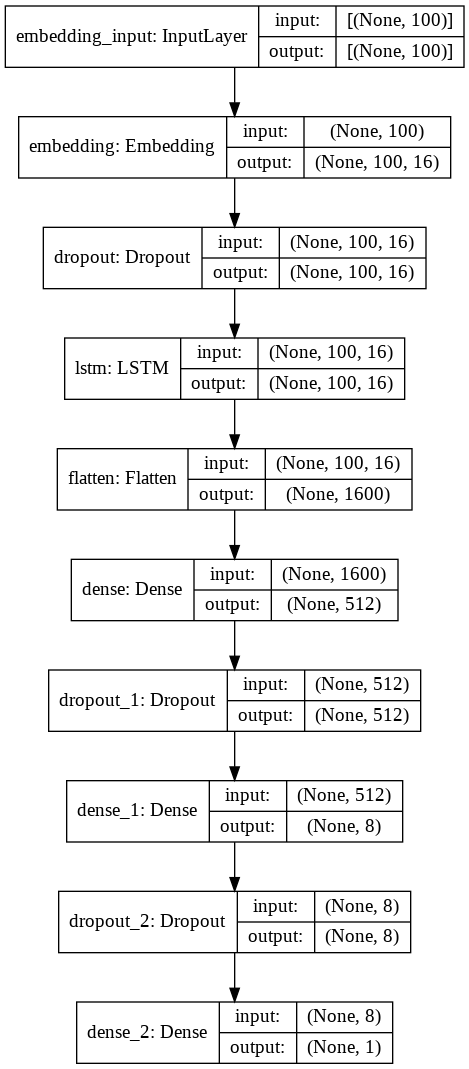

In [41]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [42]:
epochs = 10
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 8s 522ms/step - loss: 4.2758 - binary_accuracy: 0.6058 - val_loss: 3.3658 - val_binary_accuracy: 0.6312
Epoch 2/10
8/8 [==============================] - 4s 457ms/step - loss: 2.8653 - binary_accuracy: 0.6310 - val_loss: 2.2650 - val_binary_accuracy: 0.6312
Epoch 3/10
8/8 [==============================] - 4s 455ms/step - loss: 1.9471 - binary_accuracy: 0.6310 - val_loss: 1.5756 - val_binary_accuracy: 0.6312
Epoch 4/10
8/8 [==============================] - 4s 460ms/step - loss: 1.3923 - binary_accuracy: 0.6310 - val_loss: 1.1810 - val_binary_accuracy: 0.6312
Epoch 5/10
8/8 [==============================] - 4s 458ms/step - loss: 1.0819 - binary_accuracy: 0.6310 - val_loss: 0.9639 - val_binary_accuracy: 0.6312
Epoch 6/10
8/8 [==============================] - 4s 469ms/step - loss: 0.9027 - binary_accuracy: 0.6310 - val_loss: 0.8155 - val_binary_accuracy: 0.6312
Epoch 7/10
8/8 [==============================] - 4s 468ms/step - loss: 0.76

In [43]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'],'bo--', label=' training data')
    plt.plot(history.history['val_binary_accuracy'], 'ro--' ,label='validation data')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label=' training data')
    plt.plot(history.history['val_loss'],'ro--' , label='validation data')
    plt.title('Loss for Text Classification')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

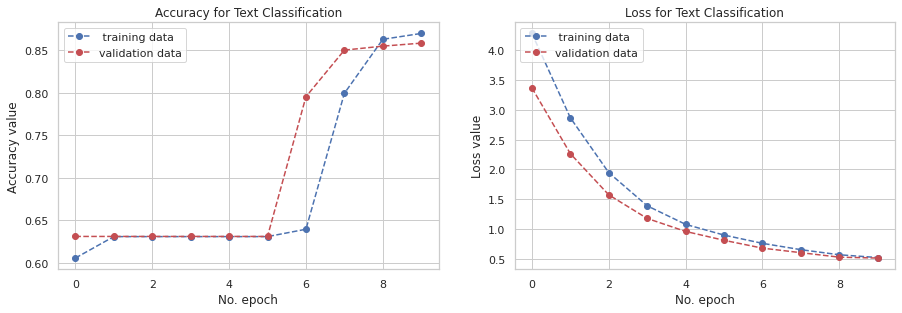

In [44]:
plot_accuracy_loss(history)

In [45]:
# saving our model and tokenizer
model.save('tf_lstmmodel.h5') 
json_string = tokenizer.to_json()

In [46]:
import json
with open('tokenizer.json', 'w') as outfile:
  json.dump(json_string, outfile)

In [48]:
# predicting
valid_predict= model.predict(X_valid)
print(valid_predict[:5])

[[0.997764  ]
 [0.90861845]
 [0.9931655 ]
 [0.1701374 ]
 [0.89914   ]]


In [49]:
def plot_roc(name, labels, predictions, **kwargs):
    fig = plt.figure(figsize=(15,10))
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [50]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

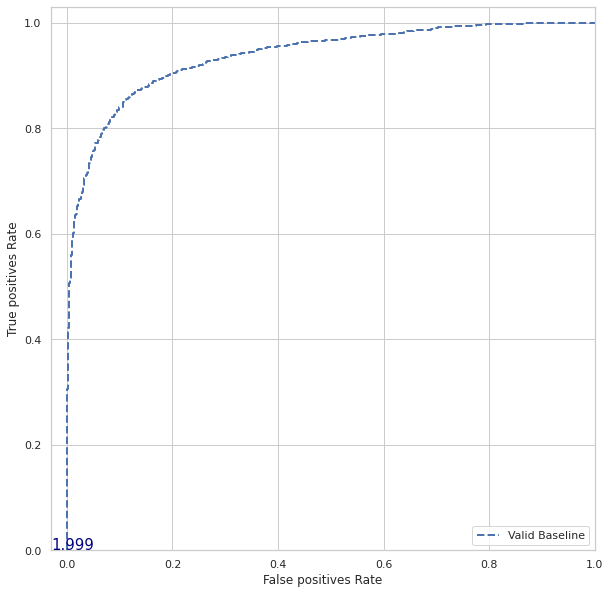

In [51]:
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [52]:
# generate model from our history
new_model = tf.keras.models.load_model('tf_lstmmodel.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

In [53]:
with open('tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [55]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewtext'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

In [57]:
predictions = new_model.predict(x_test)
test_data['pred_sentiment'] = predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.9),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.9),0,test_data.pred_sentiment)

labels = [0, 1]
    
print(classification_report(test_data['rating'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.57      0.98      0.72      6998
           1       0.99      0.63      0.77     13928

    accuracy                           0.75     20926
   macro avg       0.78      0.80      0.74     20926
weighted avg       0.85      0.75      0.75     20926



**Bi-LSTM Analysis**

It is the second step analysis. Enjoy learn!

In [58]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005))))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           800016    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 16)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 32)           4224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1638912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

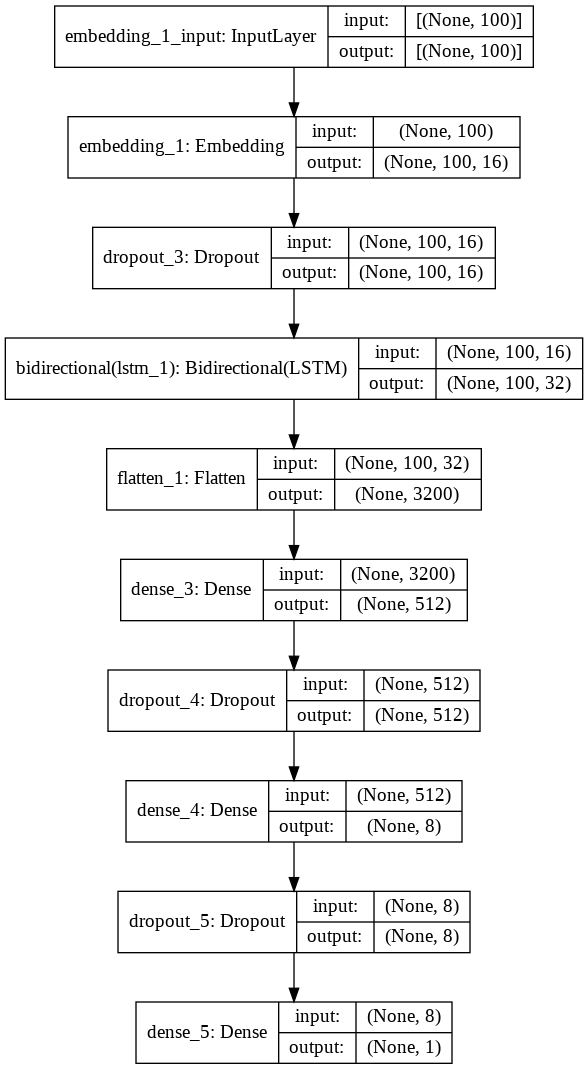

In [59]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [60]:
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 14s 980ms/step - loss: 4.5290 - binary_accuracy: 0.6090 - val_loss: 3.5711 - val_binary_accuracy: 0.6312
Epoch 2/10
8/8 [==============================] - 7s 864ms/step - loss: 3.0314 - binary_accuracy: 0.6310 - val_loss: 2.3979 - val_binary_accuracy: 0.6312
Epoch 3/10
8/8 [==============================] - 7s 870ms/step - loss: 2.0660 - binary_accuracy: 0.6310 - val_loss: 1.6729 - val_binary_accuracy: 0.6312
Epoch 4/10
8/8 [==============================] - 7s 873ms/step - loss: 1.4612 - binary_accuracy: 0.6310 - val_loss: 1.2055 - val_binary_accuracy: 0.6312
Epoch 5/10
8/8 [==============================] - 7s 871ms/step - loss: 1.0923 - binary_accuracy: 0.6310 - val_loss: 0.9513 - val_binary_accuracy: 0.6312
Epoch 6/10
8/8 [==============================] - 7s 868ms/step - loss: 0.9098 - binary_accuracy: 0.6310 - val_loss: 0.8405 - val_binary_accuracy: 0.6312
Epoch 7/10
8/8 [==============================] - 7s 871ms/step - loss: 0.8

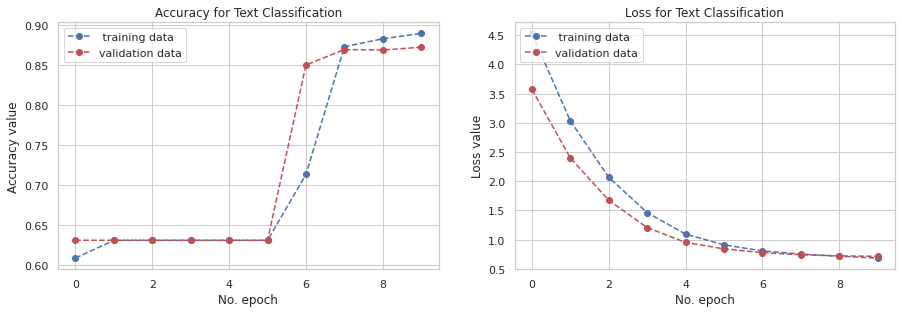

In [61]:
plot_accuracy_loss(history)

**Glove-LSTM Analysis**

It is the third step analysis. Enjoy learn!